In [1]:
import os
import pandas as pd
from glob import glob
import numpy as np
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
import audioread
import numpy as np
from numpy.random import seed
seed(2018)
import os
from tensorflow import set_random_seed
set_random_seed(2018)
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam,Adadelta,Nadam,Adamax,RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, Input, Convolution2D,Add
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, AveragePooling2D,ZeroPadding2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Model
import warnings
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, RMSprop
from keras_preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from tensorflow.keras.layers import Concatenate
warnings.filterwarnings('ignore')
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

/home/bigbrain/huy/Speech-emotion-recognition/emr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bigbrain/huy/Speech-emotion-recognition/emr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bigbrain/huy/Speech-emotion-recognition/emr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
#Get full path of all files
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

In [3]:
train_path = '/home/bigbrain/huy/Speech-emotion-recognition/images/Train/'
test_path = '/home/bigbrain/huy/Speech-emotion-recognition/images/Public_Test/'

In [4]:
data_audio = pd.read_csv('../csv/label_augmentation.csv')
# data_audio.File = data_audio.File.str.replace('.wav','.png')
data_audio.Label = data_audio.Label.astype(str)

In [5]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [6]:
train_generator_vgg=datagen.flow_from_dataframe(
    dataframe=data_audio,
    directory=train_path,
    x_col="File",
    y_col="Label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 8367 validated image filenames belonging to 6 classes.


In [7]:
valid_generator_vgg=datagen.flow_from_dataframe(
    dataframe=data_audio,
    directory=train_path,
    x_col="File",
    y_col="Label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(64,64))

Found 2091 validated image filenames belonging to 6 classes.


In [8]:
inp = Input(shape=(64,64,3))  #2D matrix of 30 MFCC bands by 216 audio length.
x = Convolution2D(32, (4,10), padding="same")(inp)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)

x = Convolution2D(32, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)

x = Convolution2D(32, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)

x = Convolution2D(32, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)

x = Flatten()(x)
x = Dense(64)(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.2)(x)

out = Dense(6, activation='softmax')(x)
model = Model(inputs=inp, outputs=out)

opt = optimizers.Adam(0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam',\
 metrics=['acc'])

In [10]:
### Train model
history = model.fit_generator(generator=train_generator_vgg,
                    steps_per_epoch=int(np.ceil(train_generator_vgg.n//float(train_generator_vgg.batch_size))),
                    validation_data=valid_generator_vgg,
                    validation_steps=int(np.ceil(valid_generator_vgg.n//float(valid_generator_vgg.batch_size))),
                    epochs=100,
                    shuffle=True,
                    verbose=1,
)

# Luu model
# model.save("../model/cnn_v2.h5")
# np.save('../npz/model_indices', train_generator_vgg.model_indices)
# with open('model_indices.pickle', 'wb') as handle:
#     pickle.dump(train_generator_vgg.model_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print("Saved model!")

Epoch 1/100
261/261 [==============================] - 10s 38ms/step - loss: 1.6479 - acc: 0.3335 - val_loss: 1.9644 - val_acc: 0.1625
Epoch 2/100
261/261 [==============================] - 8s 29ms/step - loss: 1.3997 - acc: 0.4257 - val_loss: 1.4089 - val_acc: 0.4505
Epoch 3/100
261/261 [==============================] - 8s 29ms/step - loss: 1.3093 - acc: 0.4740 - val_loss: 1.5822 - val_acc: 0.3572
Epoch 4/100
261/261 [==============================] - 8s 29ms/step - loss: 1.2469 - acc: 0.5050 - val_loss: 1.2557 - val_acc: 0.5053
Epoch 5/100
261/261 [==============================] - 8s 29ms/step - loss: 1.2052 - acc: 0.5309 - val_loss: 1.2259 - val_acc: 0.5269
Epoch 6/100
261/261 [==============================] - 8s 29ms/step - loss: 1.1726 - acc: 0.5441 - val_loss: 1.4792 - val_acc: 0.4514
Epoch 7/100
261/261 [==============================] - 8s 29ms/step - loss: 1.1253 - acc: 0.5624 - val_loss: 1.4530 - val_acc: 0.4173
Epoch 8/100
261/261 [==============================] - 8s 29m

Epoch 62/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3718 - acc: 0.8681 - val_loss: 0.7974 - val_acc: 0.7216
Epoch 63/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3712 - acc: 0.8643 - val_loss: 1.2012 - val_acc: 0.6471
Epoch 64/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3611 - acc: 0.8662 - val_loss: 1.2942 - val_acc: 0.6394
Epoch 65/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3450 - acc: 0.8758 - val_loss: 0.8873 - val_acc: 0.7082
Epoch 66/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3526 - acc: 0.8744 - val_loss: 1.9158 - val_acc: 0.5413
Epoch 67/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3517 - acc: 0.8699 - val_loss: 0.8341 - val_acc: 0.7139
Epoch 68/100
261/261 [==============================] - 8s 29ms/step - loss: 0.3679 - acc: 0.8634 - val_loss: 0.8022 - val_acc: 0.7173
Epoch 69/100
261/261 [==============================] -

In [11]:
# model.save("../model/incepv3_erc.h5")

Text(0.5, 1.0, 'Training and Validation loss')

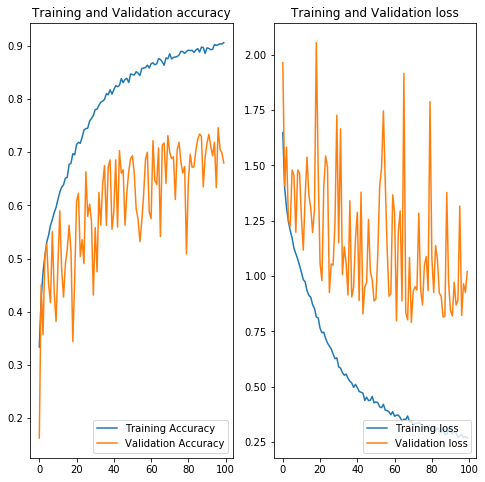

In [12]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(100)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and Validation loss")
# plt.savefig('../graphs/cnn_last.png')

In [13]:
def append_defaut(fn):
    return fn.split('.')[0] + '_defaut.png'

In [14]:
def append_ext(fn):
    return fn.replace(".wav",".png")

# Load du lieu test
testdf=pd.read_csv('./test.csv')
testdf["File"]=testdf["File"].apply(append_ext)

test_data_path=test_path

In [15]:
testdf["File"]=testdf["File"].apply(append_defaut)

In [16]:
# Khoi tao du lieu test
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_data_path,
    x_col="File",
    y_col=None,
    batch_size=14,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))

# TInh so buoc test
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# Tien hanh predict
test_generator.reset()

# batch_size = 12
# Load model da train
# model = load_model('model.h5')
pred = model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

# Lay class predict probality lon nhat
predicted_class_indices=np.argmax(pred,axis=-1)

Found 1106 validated image filenames.
79/79 [==============================] - 2s 22ms/step


In [17]:
submit_df = testdf
submit_df["Label"] = predicted_class_indices

In [18]:
def png_to_wav(fn):
    return fn.replace(".png",".wav")
submit_df["File"]=submit_df["File"].apply(png_to_wav)

In [19]:
def split_defaut(fn):
    return fn.split('_')[0] + '.wav'

submit_df["File"]=submit_df["File"].apply(split_defaut)

In [20]:
pb_test = pd.read_csv('../csv/public_label.csv')

In [21]:
count = 0
for f in submit_df.File:
    sbmit = submit_df[submit_df["File"] == f]["Label"].item()
    pbtest = pb_test[pb_test["File"] == f]["Label"].item()
    if sbmit == pbtest:
        count += 1
print(count)
print(f'Accuaracy: {round(count/len(submit_df), 4)}')

573
Accuaracy: 0.5181


# Use pre-trained model MobileNet

In [ ]:
from keras.applications import MobileNetV2

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

In [ ]:
tf.keras.backend.clear_session()

def change_model(model, new_input_shape=(None, 40, 40, 3)):
    # replace input shape of first layer
    model._layers[0].batch_input_shape = new_input_shape

    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json())

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model